# NLP: Hotel Reviews Part 2

### Audrey Gilbreath

##### August/September 2022

---


**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

## Table of Contents

[Data Dictionary](#data-dictionary)

[Analysis](#analysis)

[Part 1](#part-1)

- [Question 1a](#question-1a)
- [Question 1b](#question-1b)
- [Question 1c](#question-1c)
- [Question 1d](#question-1d)

[Part 2](#part-2)

- [Question 2a](#question-1a)
- [Question 2b](#question-1b)
- [Question 2c](#question-1c)
- [Question 2d](#question-1d)
- [Question 2e](#question-1e)

[Part 3](#part-3)

- [Question 3a](#question-3a)
- [Question 3b](#question-3b)
- [Question 3c](#question-3c)

[Part 4](#part-4)

[Part 5](#part-5)

- [Question 5a](#question-5a)
- [Question 5b](#question-5b)

[Part 6](#part-6)

- [Question 5a](#question-6a)
- [Question 5b](#question-6b)

---


**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

# Data Dictionary


The csv contains data on hotel reviews left by guests and data on the guest.

**Reviewer**  
A hotel guest who left a review.

**Hotel_Address** _object_  
Hotel address

**Additional_Number_of_Scoring** _int64_

**Review_Date** _datetime64[ns]_  
Date the review left the reviewer


**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

# Analysis


Import libraries


In [1]:
#pip install mrmr_selection

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from tempfile import mkdtemp
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
#from mrmr import mrmr_classif

Load data

In [3]:
train_df = pd.read_csv(
    '/Users/audreygilbreath/Documents/Brain Station/Deliverables/6. NLP- Hotel Review Part 2/clean_train_dataframe.csv')

train_df = pd.DataFrame(data=train_df)

test_df = pd.read_csv(
    '/Users/audreygilbreath/Documents/Brain Station/Deliverables/6. NLP- Hotel Review Part 2/clean_test_dataframe.csv')

test_df = pd.DataFrame(data=test_df)

In [4]:
train_df.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,days_since_review,lat,lng,weekday_of_review,...,n_worry,n_worth,n_would,n_write,n_wrong,n_year,n_yes,n_yet,n_young,rating
0,620,9.0,0,1974,164,1,562,51.506558,-0.004514,1,...,0,0,0,0,0,0,0,0,0,1
1,1258,9.4,6,4204,4,5,276,51.502435,-0.000250,0,...,0,0,0,0,0,0,0,0,0,1
2,995,8.1,2,3826,38,1,129,51.504348,-0.033444,0,...,0,0,0,0,0,0,0,0,0,1
3,853,8.4,7,2726,10,10,164,51.507377,0.038657,0,...,0,0,0,0,0,0,0,0,0,0
4,1243,8.1,11,6608,8,69,639,51.513556,-0.180002,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12798 entries, 0 to 12797
Columns: 2744 entries, Additional_Number_of_Scoring to rating
dtypes: float64(3), int64(2741)
memory usage: 267.9 MB


In [6]:
train_df.isna().sum().sum()

0

The train dataset has 12,798 rows and 2,744 columns, and no missing values. All values are numerical.



In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Columns: 2744 entries, Additional_Number_of_Scoring to rating
dtypes: float64(3), int64(2741)
memory usage: 89.3 MB


The test dataset has the same number of columns as train_df. And 4,267 rows, making the test set 25% of the entire set of data. There are no missing values. All values are numerical.


In [8]:
test_df.isna().sum().sum()

0

In [9]:
# Check class imbalance
print(f"train_df rating counts: \n{train_df['rating'].value_counts()}\n") # train dataframe
print(f"test_df rating counts: \n{test_df['rating'].value_counts()}") # test dataframe

train_df rating counts: 
1    7373
0    5425
Name: rating, dtype: int64

test_df rating counts: 
1    2458
0    1809
Name: rating, dtype: int64


No major or concerning discrepancy between the rating classes.

Set the X (data) and y (target) variables for train_df:


In [10]:
X_remainder = train_df.drop('rating', axis=1).copy()
y_remainder = train_df[['rating']].copy()

X_test = test_df.drop('rating', axis=1).copy()
y_test = test_df[['rating']].copy()

In [11]:
X_test.shape

(4267, 2743)

Split the train dataset to make a validation dataset.
This is a large dataset with almost 13,000 rows. I will split the train and validation sets 70/30. So, the sub-train set will be 52.5% (approx. 9,000 rows) of the entire set of data (train and test), and the validation set will be 22.5% (approx. 4,000 rows) of the entire set of data.


In [12]:
# Split X and y into train (remainder) and test sets
X_train, X_validation, y_train, y_validation = train_test_split(
    X_remainder, y_remainder, test_size=0.3, random_state=2, stratify=y_remainder)

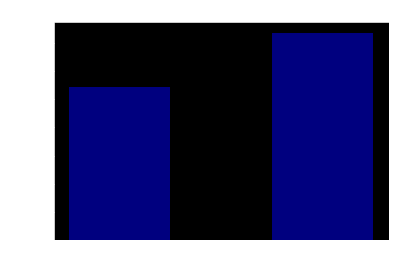

In [13]:
# Check target variable distribution
plt.figure()

plt.bar(
    x=y_remainder['rating'].value_counts().index, 
    height=y_remainder['rating'].value_counts(), 
    width=0.5, 
    color='blue', 
    alpha=0.5
)

plt.xlabel('Rating Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0: negative', '1: positive'])
plt.title('Sentiment Distribution')

plt.show()

**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

## Part 1 - Employ a linear classifier on the dataset

---

### Question 1a)

- Fit a logitistic regression model to the data with the solver set to lbfgs.
- What is the accuracy score on the test set?


In [14]:
# Instaiate estimators for pipeline
estimators1 = [
    ('scaler', StandardScaler()),  # Instantiate scaler
    ('model', LogisticRegression())  # Instantiate model
]

# Instantiate pipeline with estimators parameter
pipe1 = Pipeline(estimators1)

# Instantiate param_grid parameter for GridSearchCV
params1 = {
    'scaler': [StandardScaler()], 
    'model': [LogisticRegression(random_state=1)], 
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100], # Fitting the model using these C-values
    'model__solver': ['lbfgs'] # Optimize for multi-class data
}

# Instantiate GridSearchCV with estimators and param_grid as parameters
grid1 = GridSearchCV(pipe1, params1)

# Fitting the best found model from the gridsearch
fittedgrid1 = grid1.fit(X_remainder, y_remainder)

In [15]:
# The model parameters that gave the best
grid1.best_params_

{'model': LogisticRegression(C=0.001, random_state=1),
 'model__C': 0.001,
 'model__solver': 'lbfgs',
 'scaler': StandardScaler()}

The best `LogisticRegressmodel LogisticRegression(C=0.001, solver='lbgfs')


In [16]:
# Instantiate the estimators
estimators12 = [
    ('scaler', StandardScaler()),  # Instantiate scaler
    ('model', LogisticRegression(C=0.001, solver='lbfgs', random_state=1)) # Instantiate model
]

# Instaniate pipeline
pipe12 = Pipeline(estimators12)

# Fit pipeline to remainder data
pipe12.fit(X_remainder, y_remainder)

# Score
print(f'remainder score: {pipe12.score(X_remainder, y_remainder)}')
print(f'test score: {pipe12.score(X_test, y_test)}')

remainder score: 0.8537271448663853
test score: 0.777595500351535


The train data accuracy is 85%, and the validation has a 78% accuracy score. The data is likely overfitting since the validation score is significantly lower than the train score. The model is doing better than chance.

---

### Question 1b)

- What are the 20 words most predictive of a _good_ review (from the positive review column)?
- What are the 20 words most predictive with a _bad_ review (from the negative review column)? Use the regression coefficients to answer this question

Plan:   
Extract the regression coefficients and put them into a dataframe   
Make a bar plot of the top 20 words for positive reviews, and bottom 20 words for negative reviews.

In [17]:
# Put logistic regression coefficients and feature names in dataframe
# Coefficients from the logistic regression model
log_coef = pipe12['model'].coef_[0]

conv_coef = np.exp(log_coef) # Convert log coefficients into regular coefficients

words_coef = pd.DataFrame(data=
    {
        'coefficients': log_coef
    }, 
      index=X_remainder.columns
).sort_values(by='coefficients', ascending=False)

words_coef

,coefficients
Average_Score,0.221191
n_nothing,0.183537
n_negative,0.154883
p_excellent,0.154565
p_staff,0.138402
...,...
n_,-0.093668
p_location,-0.095321
n_small,-0.109105
n_staff,-0.129510


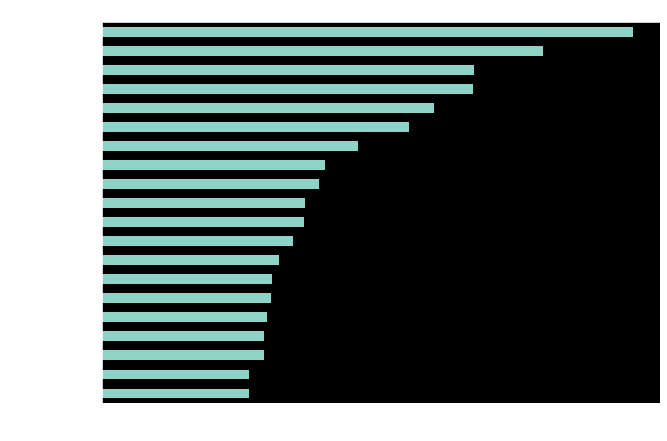

In [18]:
# Plot the top 20 predictive words for positive reviews
words_coef.head(20).sort_values(by='coefficients').plot(
    kind='barh', figsize=(10, 7), legend=False)

plt.title('Top 20 Predictive Words for Positive Reviews')
plt.xlabel('coefficients')
plt.ylabel('feature')

plt.show()

There are some "negative" words that the `LogisticRegression` is finding to be indicators of positive reviews. Perhaps it is due to reviews that say something like "I have nothing negative to say". I want to know more about if it is useful to have words separated by sentiment. For instance, "excellent" could be considered as duplicate data since there is both a "p_excellent" and "n_excellent" feature.

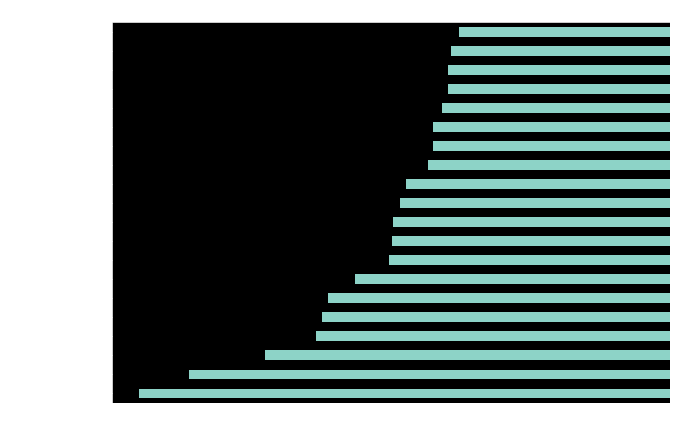

In [19]:
# Plot the top 20 predictive words for negative reviews
words_coef.sort_values(by='coefficients', ascending=True).head(
    20).plot(kind='barh', figsize=(10, 7), legend=False)

plt.title('Top 20 Predictive Words for Negative Reviews')
plt.xlabel('coefficients')
plt.ylabel('feature')

plt.show()

Another reason why there may be negative words in positive reviews and vice versa is that the original rating (which was out of 10) could have been perhaps a 7 or 8 since 9 and up are considered "positive" reviews. 

---

### Question 1c)

- Reduce the dimensionality of the dataset using PCA, what is the relationship between the number of dimensions and run-time for a logistic regression?


In [20]:
estimators13 = [
    ('scaler', StandardScaler()), 
    ('dim_reduct', PCA()),
    ('model', LogisticRegression())
]

pipe13 = Pipeline(estimators13)

params13 = [
    {
        'scaler':[StandardScaler()], 
        'dim_reduct':[PCA()], 
        'dim_reduct__n_components':[.8, .85, .9, .99], 
        'model':[LogisticRegression(C=0.001)]
    }
]

grid13 = GridSearchCV(pipe13, params13)

fittedgrid13 = grid13.fit(X_remainder, y_remainder)

In [21]:
fittedgrid13.best_params_

{'dim_reduct': PCA(n_components=0.8),
 'dim_reduct__n_components': 0.8,
 'model': LogisticRegression(C=0.001),
 'scaler': StandardScaler()}

In [22]:
# Instantiate estimators
estimators14 = [
    ('scaler', StandardScaler()), 
    ('dim_reduct', PCA(n_components=0.85)), 
    ('model', LogisticRegression(solver='lbfgs', random_state=1, C=0.001))
]

# Instantiate pipeline
pipe14 = Pipeline(estimators14)

# Fit
pipe14.fit(X_remainder, y_remainder)

# Score
print(f'remainder score: {pipe14.score(X_remainder, y_remainder)}')
print(f'test score: {pipe14.score(X_test, y_test)}')

remainder score: 0.8328645100797
test score: 0.7829857042418561


This is *slightly* better performance than the optimized `LogisticRegression` model (remainder 85.3%, test 77.7%) due to less overfitting on the remainder data plus the test score increasing a little.

In [23]:
# Extract variance ratios for each principle component
print(f"Variance captured by PC1: {pipe14['dim_reduct'].explained_variance_[0]: 0.3f}")

print(f"Variance captured by PC2: {pipe14['dim_reduct'].explained_variance_[1]: 0.3f}")

print(f"Proportion of variance captured by PC1: {pipe14['dim_reduct'].explained_variance_ratio_[0]: 0.3f}")

print(f"Proportion of variance captured by PC2: {pipe14['dim_reduct'].explained_variance_ratio_[1]: 0.3f}")


Variance captured by PC1:  20.884
Variance captured by PC2:  12.925
Proportion of variance captured by PC1:  0.008
Proportion of variance captured by PC2:  0.005


Next, I will plot the explained variance ratios for the number of components

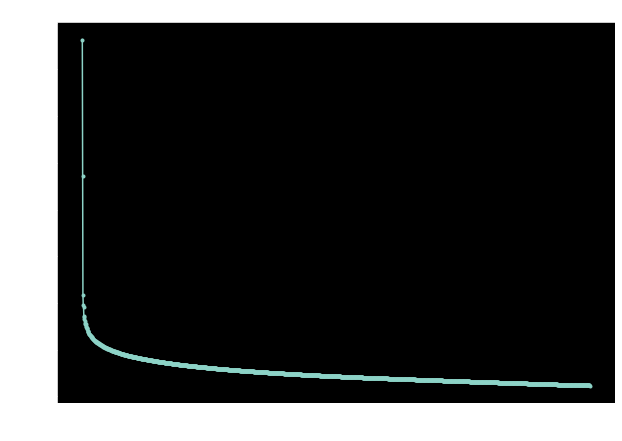

In [24]:
expl_var = pipe14['dim_reduct'].explained_variance_ratio_

plt.figure(figsize=(10, 7))

plt.plot(expl_var, marker='.')

plt.title('Explained Variance Ratios vs. Number of PCs')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Vxplained Ratios')

plt.show()

It looks like the amount of variance provided by the PCs starts to flatten after 200 or 400 PCs

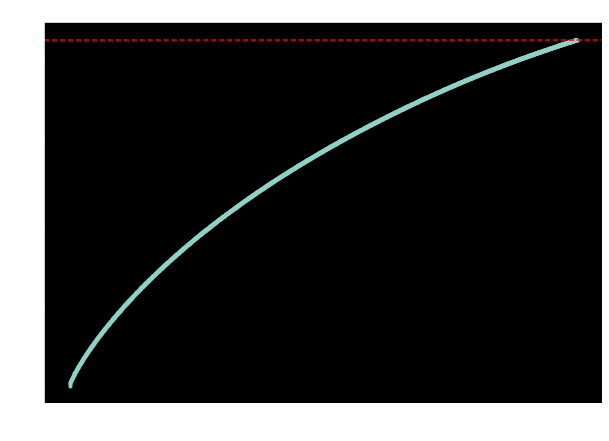

In [25]:
cumulative_sum = np.cumsum(expl_var)

cumulative_sum

plt.figure(figsize=(10, 7))
plt.plot(cumulative_sum, marker='.')

plt.title('Cumulative Sum of Explained Variance Ratios vs Number of PCs')
plt.axhline(0.85, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')

plt.show()


`PCA()` is only finding 85% of the variance within the features. instead of 100%.

In [26]:
%%timeit
pipe12.fit(X_remainder, y_remainder)

1.08 s ± 74.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
pipe12.fit(X_remainder, y_remainder)

930 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Without dimension reduction, the `LogisticRegression` has a run-time around 960 ms. With dimensional reduction, the logistic regression has a run-time around 870 ms, 90 ms faster than `pipe12`. The difference in time is due the the second `LogisticRegression` with `PCA()` has fewer features to run on and therefore has a quicker run-time.

---

### Question 1d)

- List one advantage and one disadvantage of dimensionality reduction


**Advantage**   
Can lessen the computation time

**Disadvantage**    
Interpreting the principal components is significantly more difficult

**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

## Part 2 - Employ a K-Nearest Neighbour classifier on this dataset:

---

### Question 2a)

- Fit a KNN model to this data. What is the accuracy score on the test set?


In [28]:
# Baseline KNN model
# Instantiate model
knn1 = KNeighborsClassifier() # n_neighbors is 5 by default

# Fit model on scaled remainder data
knn1.fit(X_remainder, y_remainder)

# Score model on train and validation data
print(f'remainder score: {knn1.score(X_remainder, y_remainder)}')
print(f'test score: {knn1.score(X_test, y_test)}')

remainder score: 0.7673073917799657
test score: 0.6482306069838294


The remainder baseline KNN model score is about 6 percentage points lower than the remainder optimized logistic regression model score. The remainder data has an accuracy of 77% and the test data has an accuracy of 65%. Based on the gap between the scores, the model seems to be overfitting. So far, this is the weakest baseline model, let's see what some hyperoptimization can do for us.

---

### Question 2b)

- KNN is a computationally expensive model. Reduce the number of observations (data points) in the dataset. What is the relationship between the number of observations and run-time for KNN?

To reduce the number of observations I will downsample the data using the `RandomUnderSamples()` function.

In [29]:
# Instantiate function that will be used for undersampling
rus = RandomUnderSampler(random_state=2)

# Fitting and resampling the scaled X and y data
X_remainder_resampled, y_remainder_resampled = rus.fit_resample(X_remainder, y_remainder)

# Sanity check
print(f'X_remainder shape: {X_remainder.shape}')
print(f'X_remainder_resampled shape: {X_remainder_resampled.shape}')
print(f'y_remainder shape: {y_remainder.shape}')
print(f'y_remainder_resampled shape: {y_remainder_resampled.shape}')

X_remainder shape: (12798, 2743)
X_remainder_resampled shape: (10850, 2743)
y_remainder shape: (12798, 1)
y_remainder_resampled shape: (10850, 1)


After undersampling, there are just under 2,000 rows fewer in the resampled data now, a total of 10,850 rows.       
Now the resampled data needs to be scaled.

In [30]:
# Instantiate scaler
ss = StandardScaler()

# Fit scaler to resampled data
ss.fit(X_remainder_resampled)

# Transform resampled data
X_remainder_resampled_ss = ss.transform(X_remainder_resampled)


Next are the run-times for the KNN model on the original data and the resampled data.

In [31]:
%%timeit
knn1.fit(X_remainder, y_remainder) # Run-time of KNN model on the original data

111 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit
knn1.fit(X_remainder_resampled_ss, y_remainder_resampled) # Run-time of KNN model on the resampled data

7.9 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The resampled data ran approximately 16 times faster than the original data. This is due to there being fewer observations to iterate over. The faster run-time is due to there being less data points the model has to iterate over.

---

### Question 2c)

- List one advantage and one disadvantage of reducing the number of observations.


**Advantage**       
Faster computation time since there are fewer datapoints in the dataset.

**Disadvantage**        
Risk of creating bias in dataset if the resampled data is not representative of the original data.

---

### Question 2d)

- Use the dataset to find an optimal value for K in the KNN algorithm. You will need to split your dataset into train and validation sets.


First, I will use the train and validation sets from the original remainder data set. I will use `StandardScaler()` to transform the data and I will pass 1, 5, 20, and 100 n_neighbors into `GridSearchCV`. 

In [33]:
# Instantiate estimators
estimators2 = [
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
]

# Instantiate Pipeline
pipe2 = Pipeline(estimators2)

# Instantiate parameters
params2 = [
    {
        'scaler': [StandardScaler()],
        'model':[KNeighborsClassifier()],
        'model__n_neighbors':[1, 5, 20, 100]
    }
]

# Instantiate GridSearchCV
grid2 = GridSearchCV(pipe2, params2)

# Fit GridSeachCV on train data (from original remainder dataset)
fittedgrid2 = grid2.fit(X_train, y_train)

In [34]:
fittedgrid2.best_params_

{'model': KNeighborsClassifier(n_neighbors=20),
 'model__n_neighbors': 20,
 'scaler': StandardScaler()}

In [35]:
# Use the best_params_ to model the train and validation subsets of the remainder data
# Instantiate
estimators22 = [
    ('scaler', StandardScaler()), 
    ('model', KNeighborsClassifier(n_neighbors=20))
]

# Instantiate
pipe22 = Pipeline(estimators22)

# Fit
pipe22.fit(X_train, y_train)

# Score
print(f'train score: {pipe22.score(X_train, y_train)}')
print(f'validation score: {pipe22.score(X_validation, y_validation)}')

train score: 0.7364367046215673
validation score: 0.6963541666666667


Overfit and weak accuracy score. Let's see what the resampled data can do.

In [36]:
X_train_resampled, X_validation_resampled, y_train_resampled, y_validation_resampled = train_test_split(X_remainder_resampled, y_remainder_resampled, test_size=0.3, stratify=y_remainder_resampled, random_state=2)

In [37]:
estimators23 = [
    ('scaler', StandardScaler()), 
    ('model', KNeighborsClassifier())
]

pipe23 = Pipeline(estimators23)

params23 = [
    {
        'scaler':[StandardScaler()], 
        'model':[KNeighborsClassifier()], 
        'model__n_neighbors':[1, 5, 20, 100]
    }
]

grid23 = GridSearchCV(pipe23, params23)

fittedgrid23 = grid23.fit(X_train_resampled, y_train_resampled)

In [38]:
fittedgrid23.best_params_

{'model': KNeighborsClassifier(n_neighbors=20),
 'model__n_neighbors': 20,
 'scaler': StandardScaler()}

In [39]:
# Use the best_params_ to model the train and validation subsets of the remainder data
# Instantiate
estimators24 = [
    ('scaler', StandardScaler()), 
    ('model', KNeighborsClassifier(n_neighbors=20))
]

# Instantiate pipeline
pipe24 = Pipeline(estimators24)

# Fit pipeline
pipe24.fit(X_train_resampled, y_train_resampled)

# Score
print(f'train score: {pipe24.score(X_train_resampled, y_train_resampled)}')
print(f'test score: {pipe24.score(X_validation, y_validation)}')

train score: 0.7519420671494405
test score: 0.6971354166666667


Still overfitting and unimpressive. Furthermore, the resampled score is essentially the same as the original score. This either means there's more feature engineering that can be done and or/the resampled data is a good representation of the data is comes from.

---

### Question 2e)

- What is the issue with splitting the data into train and validation sets **after** performing vectorization?

There is a risk of data leakage. If vectorization is fit on the entire dataset, then transforms the train and test data, the test data is being leaked information about the train data since it was transformed with a model that was fit on train data.

**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

## Part 3 - Employ a Decision Tree classifier on this dataset

---

### Question 3a)

- Fit a decision tree model to this data. What is the accuracy score on the test set?


In [40]:
# Baseline model
# Instantiate model
dt = DecisionTreeClassifier(max_depth=3) # I just chose an arbituary number for max_depth that would perform better than not defining max_depth

# Fit model
dt.fit(X_remainder, y_remainder)

# Score model
print(f'remainder score: {dt.score(X_remainder, y_remainder)}')
print(f'test score: {dt.score(X_test, y_test)}')

remainder score: 0.7220659478043444
test score: 0.720881181157722


The data is well fit this time, except for the fact its accuracy score is not very good.

---

### Question 3b)

- Use the data set (or a subsample) to find an optimal value for the maximum depth of the decision tree. You will need to split your data set into train and validation.


In [41]:
# GridSearch for best_params_
# Instantiate `GridSearchCV` 
estimators3 = [
    ('model', DecisionTreeClassifier())
]

pipe3 = Pipeline(estimators3)

params3 = [
    {
        'model':[DecisionTreeClassifier()], 
        'model__max_depth':[4, 6, 7, 8, 10]
    }
]

grid3 = GridSearchCV(pipe3, params3)

# Fit onto train dataset
fittedgrid3 = grid3.fit(X_train, y_train)

In [42]:
fittedgrid3.best_params_

{'model': DecisionTreeClassifier(max_depth=6), 'model__max_depth': 6}

The best max_depth for the model is 6.

In [43]:
# Use the best_params_ to model the train and validation subsets of the remainder data
# Instantiate
estimators32 = [
    ('model', DecisionTreeClassifier(max_depth=6))
]

# Instantiate
pipe32 = Pipeline(estimators32)

# Fit
pipe32.fit(X_train, y_train)

# Score
print(f'train score: {pipe32.score(X_train, y_train)}')
print(f'validation score: {pipe32.score(X_validation, y_validation)}')

train score: 0.7659075686537173
validation score: 0.7473958333333334


Still not great, but this is an improvement in that the model is not overfitting or underfitting the data. The `LogisticRegression` model has had the best performance so far.

---

### Question 3c)

- Provide two advantages of decision trees over KNN. Provide two weaknesses of decision trees (classification or regression trees).


**Advantages**      
1. Decisions trees have a faster run-time
2. Decision trees predictions are easy to understand
3. Decision trees can be used with numeric or nominal data, where KNN can only work with numeric.

**Disadvantages**
1. Overfitting is a risk with Decision trees if the max_depth is set too high.
2. Sensitivity to outliers

**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

## Part 4

---

### Question 4)

- What is the purpose of the validation set, i.e., how is it different than the test set?


The purpose of the validation set is to prevent data leakage into the test set. Say we fit a `GridSearchCV()` to the train set, pull the `best_params_`, fit another model on the train set using the `best_params_`, and score the test data. The leakage happens in this scenaria when the `best_params_` have been found using the test set, and then are being used to fine tune a model for the test set.      

Another way to think about the validation set is that it's a sub-test set formed from the train_set. A test set is used to act as data that's not collected yet. So when hyperoptimizing a model, the test set needs to be treated as if the data hasn't been collected yet, hence the validation set, or test set 2.0, that the model can run on without leaking into the test set.

**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

## Part 5 - Re-run a decision tree or logistic regression

---

### Question 5a)

- Perform a 5-fold cross validation to optimize the hyperparameters of your model.


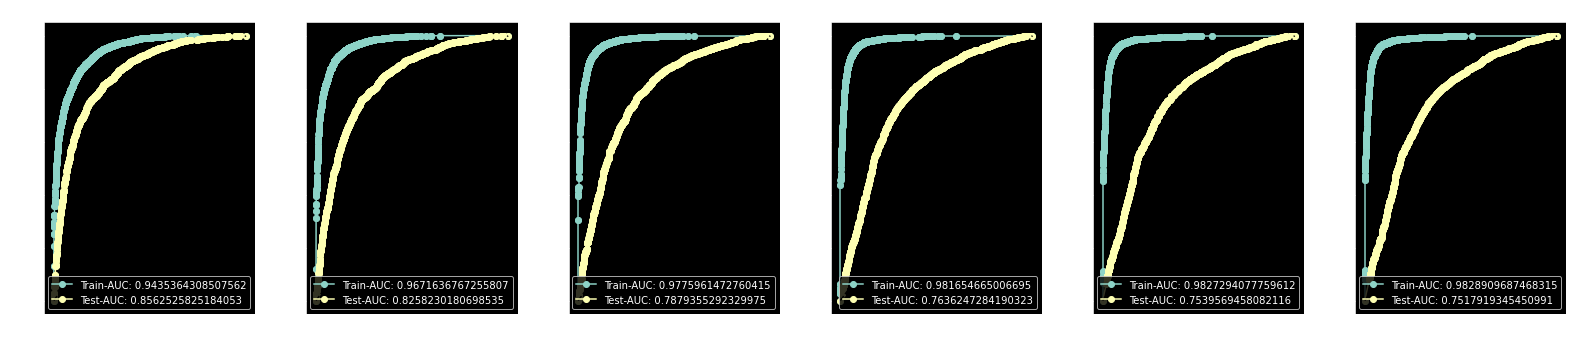

In [44]:
# Instantiate - list of models
my_models = [LogisticRegression(C=0.001), LogisticRegression(C=0.01), LogisticRegression(C=0.1), LogisticRegression(C=1),LogisticRegression(C=10), LogisticRegression(C=100)]

# Fit Scaler
ss.fit(X_train)

#transform scaler
X_train_ss = ss.transform(X_train)
X_validation_ss = ss.transform(X_validation)

# Instantiate subplots
fig, axes = plt.subplots(1, 6, figsize=(22, 5))

# FOR EACH MODEL
for index, model in enumerate(my_models):

    # Fit
    model.fit(X_train_ss, y_train)

    # Make (soft) predictions
    y_train_proba = model.predict_proba(X_train_ss)[:, 1]
    y_validation_proba = model.predict_proba(X_validation_ss)[:, 1]

    # Score (calculate AUC)
    train_auc = roc_auc_score(y_train, y_train_proba)
    validation_auc = roc_auc_score(y_validation, y_validation_proba)

    # Plot ROC curves
    plot_roc_curve(model, X_train_ss, y_train, ax=axes[index], label=f'Train-AUC: {train_auc}', marker='o')
    axes[index].plot([0, 1], [0, 1], color='black', linestyle='--')
    plot_roc_curve(model, X_validation_ss, y_validation, ax=axes[index], label=f'Test-AUC: {validation_auc}', marker='o')
    axes[index].plot([0, 1], [0, 1], color='black', linestyle='--')
    axes[index].set_title(f'ROC for {model}')

plt.tight_layout()
plt.show()


A `LogisticRegression` with C=0.001 has the best performace. The test is overfitting some on the training data, but the other `LogisticRegression` with other values of C are more so, especially as C increase, the model overfits even more on the train dataset.

In [45]:
C_range = np.array([.000001,.00001,.0001,.001,.1,1,10,100,1000000,10000000])

# Instantiate estimators
estimators5 = [
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression())
]

# Instantiate pipeline
pipe5 = Pipeline(estimators5)

# Instantiate parameters
params5 = [
    {
        'scaler':[StandardScaler()], 
        'model':[LogisticRegression(random_state=2)], 
        'model__C':[.000001, .00001, .0001, .001, .1, 1, 10, 100, 1000000, 10000000],
        'model__solver':['lbfgs', 'saga']
    }
]

# Instantiate `GridSearchCV()` with estimators and parameters
grid5 = GridSearchCV(pipe5, params5, cv=5)

# Fit `GridSearchCV` on the remainder datasets
fittedgrid5 = grid5.fit(X_remainder, y_remainder)

In [46]:
# Extracting the mean cv scores
cross_validation_scores = fittedgrid5.cv_results_['mean_test_score']
cross_validation_scores

array([0.57673069, 0.57680881, 0.64494441, 0.6468979 , 0.76887032,
       0.77051116, 0.77629292, 0.77598036, 0.73394264, 0.76043028,
       0.72401881, 0.75964891, 0.72011168, 0.75972704, 0.71995552,
       0.75972704, 0.71948677, 0.75972704, 0.71956489, 0.75972704])

In [47]:
# Extracting best parameters
fittedgrid5.best_params_

{'model': LogisticRegression(C=0.001, random_state=2),
 'model__C': 0.001,
 'model__solver': 'lbfgs',
 'scaler': StandardScaler()}

The best model parameters are LogisticRegression(C=0.001, solver='lbfgs', random_state=2) with a 5-fold cross validation.

In [48]:
print(f'train score: {fittedgrid5.score(X_train, y_train)}')
print(f'validation score: {fittedgrid5.score(X_validation, y_validation)}')

train score: 0.8542085286894396
validation score: 0.8526041666666667


These are best scores yet, both have the highest accuracy so far and there's no overfitting. Better accuracry would be nice, however.
This is the best accuracy and it aligns with the maximum explained variance the PCA() could account for.

---

### Question 5b)

- What does your confusion matrix look like for your best model on the test set?


In [49]:
# Make predictions
y_train_pred = dt.predict(X_train_ss)
y_validation_pred = dt.predict(X_validation_ss)

In [50]:
# Generate confusion matrix for train dataset
cf_train = confusion_matrix(y_train, y_train_pred)

# Santiy check
cf_train

array([[ 103, 3694],
       [  17, 5144]])

              precision    recall  f1-score   support

           0       0.86      0.03      0.05      3797
           1       0.58      1.00      0.73      5161

    accuracy                           0.59      8958
   macro avg       0.72      0.51      0.39      8958
weighted avg       0.70      0.59      0.45      8958



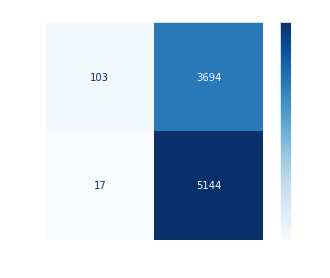

In [51]:
# confustion matrix for train dataset
plot_confusion_matrix(dt, X_train_ss, y_train, cmap='Blues', display_labels=y_train.value_counts().index)

plt.title('Confusion Matrix for Train dataset')

# Classification report for train set
cf_train_report = classification_report(y_train, y_train_pred)

# Sanity check
print(cf_train_report)


There's som eover fitting with recall for positive reviews, and abysmal recall and f1-scores for negative reviews.

In [52]:
# Generate confusion matrix for validation dataset
cf_validation = confusion_matrix(y_validation, y_validation_pred)

# Santiy check
cf_validation

array([[  51, 1577],
       [   3, 2209]])

              precision    recall  f1-score   support

           0       0.94      0.03      0.06      1628
           1       0.58      1.00      0.74      2212

    accuracy                           0.59      3840
   macro avg       0.76      0.51      0.40      3840
weighted avg       0.74      0.59      0.45      3840



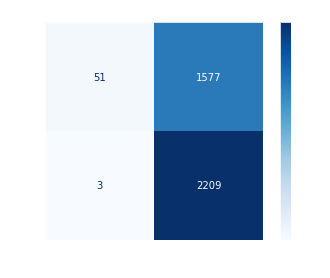

In [53]:
# confustion matrix for validation dataset
plot_confusion_matrix(dt, X_validation_ss, y_validation, cmap='Blues',
                      display_labels=y_validation.value_counts().index)


plt.title('Confusion Matrix for Test dataset')

# Classification report for validation set
cf_validation_report = classification_report(y_validation, y_validation_pred)

# Sanity check
print(cf_validation_report)


Still overfitting in recall for positive reviews and abysmal recall and f1-scores for negative reviews. High precision for negative reviews but barely better than chance in precision for positive reviews.

**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**

## Part 6 - Create one new feature of my choice

---

### Question 6a)

- Explain the new feature and why it will improve accuracy.


For this I will clean up some issues and concern I have with the dataset provided. I have concerns about the hotel data (location, last dat since contacted, etc.) being fit on the model and skewing data. The goal here is to do sentiment analysis on the written reviews. A bad hotel will be able to provide negative reviews that is needed for this project, but having information about the hotel with out text data means the models are fitting on it and using it to determine the dependent variable. 

I will drop data that doesn't belong in the document-term matrix:
- Hotel information
- The prefixes that are currently in the corpus ("p_" and "n_")
- Drop the columns "p_ " and "n_ " as they are typos and not indicators of sentiment.
- Combine positive and negative words that are the same. For instance, "p_excellent" and "n_excellent" will become "excellent".

Drop the hotel informatin columns:

In [54]:
train_df2 = train_df.drop(train_df.iloc[:, 0:417], axis=1).copy()
train_df2

,p_,p_02,p_1,p_10,p_100,p_11,p_12,p_15,p_1st,p_2,...,n_worry,n_worth,n_would,n_write,n_wrong,n_year,n_yes,n_yet,n_young,rating
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12793,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12794,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12795,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12796,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
test_df2 = test_df.drop(test_df.iloc[:, 0:417], axis=1).copy()
test_df2

,p_,p_02,p_1,p_10,p_100,p_11,p_12,p_15,p_1st,p_2,...,n_worry,n_worth,n_would,n_write,n_wrong,n_year,n_yes,n_yet,n_young,rating
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4264,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4265,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Drop columns "p_" and "n_" as they are just likely frequent typos and not indicators of sentiment.

In [56]:
train_df2 = train_df2.drop(['p_', 'n_'], axis=1).copy()
train_df2

,p_02,p_1,p_10,p_100,p_11,p_12,p_15,p_1st,p_2,p_20,...,n_worry,n_worth,n_would,n_write,n_wrong,n_year,n_yes,n_yet,n_young,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test_df2 = test_df2.drop(['p_', 'n_'], axis=1).copy()
test_df2

,p_02,p_1,p_10,p_100,p_11,p_12,p_15,p_1st,p_2,p_20,...,n_worry,n_worth,n_would,n_write,n_wrong,n_year,n_yes,n_yet,n_young,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Remove the "p_" and "n_" prefixes. These prefixes are causing multi-collinearity with frequent words that show up in both the positive and the negative reviews. The prefixes also make it difficult to detect frequent words that appear in both positive and negative reviews since a single word is getting two columns.

In [58]:
cols = train_df2.columns.str.removeprefix('p_').str.removeprefix('n_')
train_df2.columns = cols
train_df2

,02,1,10,100,11,12,15,1st,2,20,...,worry,worth,would,write,wrong,year,yes,yet,young,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
cols = test_df2.columns.str.removeprefix('p_').str.removeprefix('n_')
test_df2.columns = cols
test_df2

,02,1,10,100,11,12,15,1st,2,20,...,worry,worth,would,write,wrong,year,yes,yet,young,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To finish the data preprocessing, the duplicate columns will be combined and summed.

In [60]:
train_df2 = train_df2.groupby(axis=1, level=0).sum().copy()
train_df2

,00,02,1,10,100,11,11am,11pm,12,15,...,wow,write,wrong,x,yard,year,yes,yet,young,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
test_df2 = test_df2.groupby(axis=1, level=0).sum().copy()
test_df2

,00,02,1,10,100,11,11am,11pm,12,15,...,wow,write,wrong,x,yard,year,yes,yet,young,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4263,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Sanity check that the target variable was not effected. Same value counts as before, all is good.

display(train_df['rating'].value_counts())
display(train_df2['rating'].value_counts())

1    7373
0    5425
Name: rating, dtype: int64

1    7373
0    5425
Name: rating, dtype: int64

There are now 1,576 feature in the dataset, much better. The idea here is that this will help the models determine which features are indicators of sentiment. For instance, is the word "excellent" really an indicator of sentiment since it was one of the most frequent words for positive and negative reviews? 

Next, I will split this modified dataset.

In [63]:
X2_remainder = train_df2.drop('rating', axis=1).copy()
y2_remainder = train_df2[['rating']].copy()

X2_test = test_df2.drop('rating', axis=1).copy()
y2_test = test_df2[['rating']].copy()

In [64]:
# Sanity check
X2_test.shape

(4267, 1575)

In [65]:
# Split X and y into train (remainder) and test sets
X2_train, X2_validation, y2_train, y2_validation = train_test_split(
    X2_remainder, y2_remainder, test_size=0.3, random_state=2, stratify=y2_remainder)

---

### Question 6b)

- Run the model from question 5 again. You will have to re-optimize your hyperparameters. Has the accuracy score of your best model improved on the test set after adding the new feature you created?


---


A `LogisticRegression` with C=0.001 has the best performace. The test is overfitting some on the training data, but the other `LogisticRegression` with other values of C are more so, especially as C increase, the model overfits even more on the train dataset.
This is also weaker performanc than before dropping the hotel information and token prefixes.

In [66]:
# Fit `GridSearchCV` from question 5 onto the remainder2 datasets
fittedgrid5 = grid5.fit(X2_remainder, y2_remainder)

In [67]:
fittedgrid5.best_params_

{'model': LogisticRegression(C=0.001, random_state=2),
 'model__C': 0.001,
 'model__solver': 'lbfgs',
 'scaler': StandardScaler()}

The best parameters are still the same with the modified dataset.

In [68]:
fittedgrid5.best_score_

0.7609778294744041

The best score is worse than the score from question 5, and about the same as previous models.

Let's try being even more intentional with the features we use by applying `SelectKBest` on the dataset.

In [69]:
# Instantiate `GridSearchCV`
estimators = [
    ('kbest', SelectKBest(f_regression)), 
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression())
]

pipe = Pipeline(estimators)

params = [
    {
        'kbest':[SelectKBest(f_regression)], 
        'kbest__k':[10, 50, 75, 100, 150, 200], 
        'scaler':[StandardScaler(), None], 
        'model':[LogisticRegression()], 
        'model__C':[.000001, .00001, .0001, .001, .1, 1, 10, 100, 1000000, 10000000],
        'model__solver':['lbfgs'], 
        'model__penalty':['l2']
    }
]

grid = GridSearchCV(pipe, params, cv=5)

# Fit to modified train dataset
fittedgrid = grid.fit(X2_train, y2_train)

In [70]:
fittedgrid.best_params_

{'kbest': SelectKBest(k=150, score_func=<function f_regression at 0x7fb0809daa60>),
 'kbest__k': 150,
 'model': LogisticRegression(C=0.1),
 'model__C': 0.1,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs',
 'scaler': StandardScaler()}

In [71]:
fittedgrid.best_score_

0.7604364830102895

In [72]:
# running pipeline with the above best parameters on train and test sets
estimators =[
    ('kbest', SelectKBest(f_regression, k=150)), 
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(C=0.1, penalty='l2', solver='lbfgs'))
]

pipe = Pipeline(estimators)

pipe.fit(X2_remainder, y2_remainder)

print(f'train score: {pipe.score(X2_remainder, y2_remainder)}')
print(f'validation score score: {pipe.score(X2_test, y2_test)}')

train score: 0.76629160806376
validation score score: 0.7506444808999297


Less overfitting, but not great accuracy.

### Final Thoughts

Other options for feature engineering, are dropping the prefixes, but keeping the hotel information, which I still don't think is necessary. Taking a closer look at the words in the corpus that appear in both positive and negative reviews with high frequency could also be dropped, such as excellent. All the models used overfitted, except for the 5-fold cross-validation used with LogisticRegression in part 5a. 